## Data Construction: Geographical Model

We construct the geographical model dataset from preprocessed training and test splits, restricting attention to impressions within each user’s first 150 exposures. Eligibility is computed jointly across the combined train–test data to preserve the true chronological ordering of impressions within users.

The feature set includes spatial and temporal numerical variables (`TIME`, `LATITUDE`, `LONGITUDE`) and contextual categorical variables (`MEDIA_PACKAGE_NAME_EMBEDDING`, `MODEL_EMBEDDING`, `BRAND_ID_EMBEDDING`, `OPERATOR_ID_EMBEDDING`, `ISP_ID_EMBEDDING`, `CURRENT_AD_ID`, `CITY`, `PROVINCE`). All categorical features are cast as categorical types.

The outcome variable is a binary click indicator (`CLICK`). Final training and test feature matrices and labels are exported as CSV files for XGBoost estimation.


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

train_data = pd.read_csv("preprocessed_train_data.csv").copy()
test_data  = pd.read_csv("preprocessed_test_data.csv").copy()

print(f"Training rows before ≤150-impression filter : {len(train_data):,}")
print(f"Testing rows before ≤150-impression filter : {len(test_data):,}")

combo = pd.concat(
    [train_data[["Unique_ID", "ANDROID_ID"]],
     test_data[["Unique_ID",  "ANDROID_ID"]]],
    ignore_index=True
).sort_values(["ANDROID_ID", "Unique_ID"])

combo["order_idx"] = combo.groupby("ANDROID_ID").cumcount().add(1)
ELIGIBLE = set(combo.loc[combo["order_idx"] <= 150, "Unique_ID"])

print(f"Training rows after ≤150-impression filter : {len(train_data):,}")
print(f"Testing rows after ≤150-impression filter : {len(test_data):,}")

categorical_features = [
    'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING',
    'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING',
    'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', "CITY", "PROVINCE"
]

numerical_features = [
    'TIME',
    'LATITUDE', 'LONGITUDE'
]

all_features = numerical_features + categorical_features

X_train = train_data[all_features].copy()
y_train = train_data["CLICK"].copy()

X_test  = test_data[all_features].copy()
y_test  = test_data["CLICK"].copy()

for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col]  = X_test[col].astype("category")

print("\nColumns in X_train:")
print(list(X_train.columns))

print("\nColumns in X_test:")
print(list(X_test.columns))

X_train.to_csv("xgboost_X_train_G.csv", index=False)
y_train.to_csv("xgboost_y_train_G.csv", index=False)
X_test.to_csv("xgboost_X_test_G.csv",  index=False)
y_test.to_csv("xgboost_y_test_G.csv",  index=False)

print("Prepared data for XGBoost saved.")

/tmp/ipykernel_2539600/2077121048.py:11: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data  = pd.read_csv("preprocessed_test_data.csv").copy()


Training rows before ≤150‑impression filter : 6,356,413
Testing rows before ≤150‑impression filter : 4,180,766
Training rows after ≤150‑impression filter : 6,356,413
Testing rows after ≤150‑impression filter : 4,180,766

Columns in X_train:
['TIME', 'LATITUDE', 'LONGITUDE', 'Unique_ID', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', 'CITY', 'PROVINCE']

Columns in X_test:
['TIME', 'LATITUDE', 'LONGITUDE', 'Unique_ID', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', 'CITY', 'PROVINCE']
Prepared data for XGBoost saved.


## Model Estimation and Evaluation: Geographical Model

We estimate a binary XGBoost classifier using the geographical feature set, with categorical variables handled natively via XGBoost’s categorical split functionality. The model is trained on the training data and validated on the held-out test set using early stopping based on validation AUC.

Model performance is evaluated relative to a constant-prediction baseline defined by the training click-through rate (CTR). We report log loss and relative information gain (RIG), along with standard classification metrics including AUC, Gini, accuracy, precision, recall, F1 score, and average precision (AP).

In addition, we assess predictive quality using ROC and precision–recall curves and summarize classification outcomes with a confusion matrix. Predicted click probabilities are merged back into the test dataset for downstream analysis. The trained model is saved for reproducibility.


/tmp/ipykernel_2539600/2547553168.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('xgboost_y_train_GG.csv', header=None).values.flatten()
/tmp/ipykernel_2539600/2547553168.py:20: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  y_test = pd.read_csv('xgboost_y_test_GG.csv', header=None).values.flatten()



Columns in X_train:
['TIME', 'LATITUDE', 'LONGITUDE', 'Unique_ID', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', 'CITY', 'PROVINCE']

Columns in X_test:
['TIME', 'LATITUDE', 'LONGITUDE', 'Unique_ID', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', 'CITY', 'PROVINCE']

Training XGBoost model with test data as validation set...
[0]	validation-auc:0.70686
[1]	validation-auc:0.70572
[2]	validation-auc:0.69845
[3]	validation-auc:0.68422
[4]	validation-auc:0.70669
[5]	validation-auc:0.70331
[6]	validation-auc:0.71107
[7]	validation-auc:0.70811
[8]	validation-auc:0.70481
[9]	validation-auc:0.70072
[10]	validation-auc:0.69487
[11]	validation-auc:0.69012
[12]	validation-auc:0.68722
[13]	validation-auc:0.68353
[14]	validation-auc:0.70108
[15]	validation-auc:0.69703
[16]	validation-auc:0.70705
[17]	validation-auc:0.70471
[

/tmp/ipykernel_2539600/2547553168.py:241: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("preprocessed_test_data.csv").copy()


Test data with predictions saved to 'XGB_test_data_with_predictions.csv'.
XGBoost model saved to 'xgb_model.bin'.


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


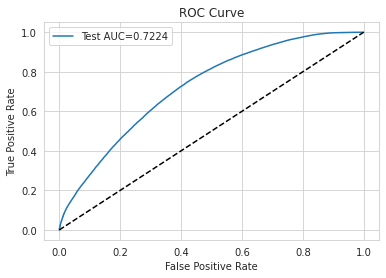

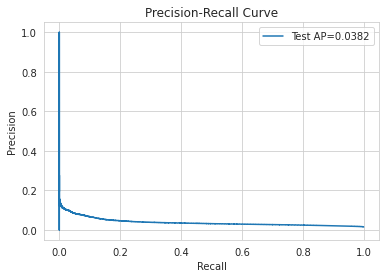

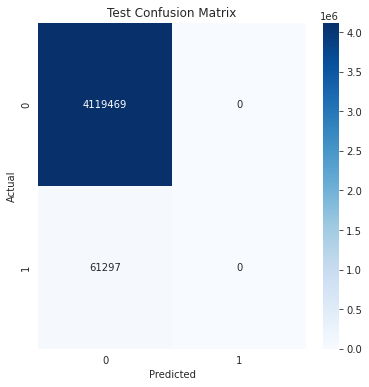

In [56]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, average_precision_score,
    log_loss, roc_curve, precision_recall_curve
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

X_train = pd.read_csv('xgboost_X_train_G.csv')
y_train = pd.read_csv('xgboost_y_train_G.csv', header=None).values.flatten()
X_test = pd.read_csv('xgboost_X_test_G.csv')
y_test = pd.read_csv('xgboost_y_test_G.csv', header=None).values.flatten()

print("\nColumns in X_train:")
print(list(X_train.columns))

print("\nColumns in X_test:")
print(list(X_test.columns))

y_train = y_train[1:].astype(int)
y_test = y_test[1:].astype(int)

categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

evals = [(dval, 'validation')]

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': 6,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'eta': 0.1,
    'max_depth': 10,
    'colsample_bytree': 0.5,
    'seed': 45
}

num_boost_round = 300
early_stopping_rounds = 14

print("\nTraining XGBoost model with test data as validation set...")
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True,
)

baseline_ctr = y_train.mean()
baseline_loss = -(
    baseline_ctr * np.log(baseline_ctr + 1e-9) +
    (1 - baseline_ctr) * np.log(1 - baseline_ctr + 1e-9)
)

test_preds = model.predict(dval)
test_loss = log_loss(y_test, test_preds)
test_rig = (1 - test_loss / baseline_loss) * 100
test_accuracy = accuracy_score(y_test, test_preds >= 0.5)
test_auc = roc_auc_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds >= 0.5, zero_division=0)
test_recall = recall_score(y_test, test_preds >= 0.5, zero_division=0)
test_f1 = f1_score(y_test, test_preds >= 0.5, zero_division=0)
test_cm = confusion_matrix(y_test, test_preds >= 0.5)
test_ap = average_precision_score(y_test, test_preds)
test_gini = 2 * test_auc - 1
Y_Avg = test_preds.mean()

print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}, RIG: {test_rig:.2f}%, AUC: {test_auc:.4f}, Gini: {test_gini:.4f}")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Average Precision (AP): {test_ap:.4f}, Mean Y Predicted: {Y_Avg:.4f}")
print("Confusion Matrix:")
print(test_cm)

fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test AUC={test_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

precision_test, recall_test, _ = precision_recall_curve(y_test, test_preds)
plt.figure()
plt.plot(recall_test, precision_test, label=f"Test AP={test_ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

test_data = pd.read_csv("preprocessed_test_data.csv").copy()

if len(test_data) != len(test_preds):
    raise ValueError("Mismatch between test_data and test_preds length.")

test_data['Predicted_Y'] = test_preds
test_data['Actual_Y'] = y_test

print("Test data with predictions saved to 'XGB_test_data_with_predictions.csv'.")

model.save_model("xgb_model_G.bin")
print("XGBoost model saved to 'xgb_model.bin'.")

### Counterfactual Estimation

We conduct counterfactual prediction using the trained geographical XGBoost model to evaluate how predicted engagement would change under alternative ad assignments. After loading the saved model and the held-out test feature matrix, we first generate **factual predictions** corresponding to the observed ad shown in each impression.

To construct counterfactuals, we systematically replace the ad identifier feature (`CURRENT_AD_ID`) with alternative ad IDs while holding all other contextual and geographical features fixed. For each impression, we compute predicted click probabilities under a fixed set of counterfactual ads, yielding an impression-by-ad matrix of counterfactual outcomes.

The output dataset includes unique impression identifiers, factual predictions, observed outcomes, the actual ad shown, and predicted counterfactual outcomes for each alternative ad. This structure enables policy evaluation and comparison of ad assignment rules under a fixed geographical information regime.


In [57]:
import pandas as pd, numpy as np, xgboost as xgb

print("Loading saved model and test matrices …")
MODEL_PATH = "xgb_model_G.bin"
XTEST_PATH = "xgboost_X_test_G.csv"
YTEST_PATH = "xgboost_y_test_G.csv"
PREPROC_TEST = "preprocessed_test_data.csv"

booster = xgb.Booster()
booster.load_model(MODEL_PATH)

X_test = pd.read_csv(XTEST_PATH)
y_test = pd.read_csv(YTEST_PATH, header=None).values.flatten()[1:].astype(int)

meta_test = pd.read_csv(PREPROC_TEST)
if len(meta_test) != len(X_test):
    raise ValueError("Row mismatch between feature matrix and meta file.")

unique_id_col = "Unique_ID" if "Unique_ID" in meta_test.columns else meta_test.columns[0]
unique_ids = meta_test[unique_id_col].values
actual_ad_col = "CURRENT_AD_ID"
actual_ads = meta_test[actual_ad_col].values

ad_feat_col = "CURRENT_AD_ID"
if ad_feat_col not in X_test.columns:
    raise ValueError(f"Feature column '{ad_feat_col}' not found in X_test!")

dtest = xgb.DMatrix(X_test)
factual_pred = booster.predict(dtest)

NUM_ADS_CF = 10
cf_preds = np.zeros((len(X_test), NUM_ADS_CF))

print("Predicting counter-factuals …")
for ad_id in range(NUM_ADS_CF):
    X_cf = X_test.copy()
    X_cf[ad_feat_col] = ad_id
    d_cf = xgb.DMatrix(X_cf)
    cf_preds[:, ad_id] = booster.predict(d_cf)
    print(f"  finished ad {ad_id}")

out_cols = {
    "Unique_ID": unique_ids,
    "Predicted_Y": factual_pred,
    "Actual_Y": y_test,
    "Actual_Ad_ID": actual_ads
}
for ad_id in range(NUM_ADS_CF):
    out_cols[f"cf_ad_{ad_id}"] = cf_preds[:, ad_id]

out_df = pd.DataFrame(out_cols)
out_df.to_csv("Models/val_counterfactual_predictions_Geographical.csv", index=False)
print("✓ counterfactual_predictions.csv written.")

Loading saved model and test matrices …


/tmp/ipykernel_2539600/632949836.py:27: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  y_test    = pd.read_csv(YTEST_PATH, header=None).values.flatten()[1:].astype(int)
/tmp/ipykernel_2539600/632949836.py:29: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_test = pd.read_csv(PREPROC_TEST)            # same order as X_test by construction


Predicting counter-factuals …
  finished ad 0
  finished ad 1
  finished ad 2
  finished ad 3
  finished ad 4
  finished ad 5
  finished ad 6
  finished ad 7
  finished ad 8
  finished ad 9
✓ counterfactual_predictions.csv written.


## Data Construction: Contextual Model

We construct the contextual model dataset from preprocessed training and test splits, restricting the sample to impressions within each user’s first 150 exposures, with eligibility determined jointly across the combined data to preserve within-user chronology.

The feature set includes temporal numerical variables (`TIME`, `HOUR_SIN`, `HOUR_COS`, `MINUTE_SIN`, `MINUTE_COS`) and contextual categorical variables (`MEDIA_PACKAGE_NAME_EMBEDDING`, `MODEL_EMBEDDING`, `BRAND_ID_EMBEDDING`, `OPERATOR_ID_EMBEDDING`, `ISP_ID_EMBEDDING`, `CURRENT_AD_ID`). All categorical features are cast as categorical types.

The outcome variable is a binary click indicator (`CLICK`). Final training and test datasets are exported for XGBoost estimation.


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

train_data = pd.read_csv("preprocessed_train_data.csv").copy()
test_data  = pd.read_csv("preprocessed_test_data.csv").copy()

print(f"Training rows before ≤150-impression filter : {len(train_data):,}")
print(f"Testing rows before ≤150-impression filter : {len(test_data):,}")

combo = pd.concat(
    [train_data[["Unique_ID", "ANDROID_ID"]],
     test_data[["Unique_ID",  "ANDROID_ID"]]],
    ignore_index=True
).sort_values(["ANDROID_ID", "Unique_ID"])

combo["order_idx"] = combo.groupby("ANDROID_ID").cumcount().add(1)
ELIGIBLE = set(combo.loc[combo["order_idx"] <= 150, "Unique_ID"])

print(f"Training rows after ≤150-impression filter : {len(train_data):,}")
print(f"Testing rows after ≤150-impression filter : {len(test_data):,}")

categorical_features = [
    'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING',
    'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING',
    'ISP_ID_EMBEDDING', 'CURRENT_AD_ID'
]

numerical_features = [
    'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS',
    'LATITUDE', 'LONGITUDE'
]

numerical_features = [
    'TIME', 'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS'
]

all_features = numerical_features + categorical_features

X_train = train_data[all_features].copy()
y_train = train_data["CLICK"].copy()

X_test  = test_data[all_features].copy()
y_test  = test_data["CLICK"].copy()

for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col]  = X_test[col].astype("category")

print("\nColumns in X_train:")
print(list(X_train.columns))

print("\nColumns in X_test:")
print(list(X_test.columns))

X_train.to_csv("xgboost_X_train_C.csv", index=False)
y_train.to_csv("xgboost_y_train_C.csv", index=False)
X_test.to_csv("xgboost_X_test_C.csv",  index=False)
y_test.to_csv("xgboost_y_test_C.csv",  index=False)

print("Prepared data for XGBoost saved.")

/tmp/ipykernel_2909580/3571897024.py:11: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data  = pd.read_csv("preprocessed_test_data.csv").copy()


Training rows before ≤150‑impression filter : 6,356,413
Testing rows before ≤150‑impression filter : 4,180,766
Training rows after ≤150‑impression filter : 6,356,413
Testing rows after ≤150‑impression filter : 4,180,766

Columns in X_train:
['TIME', 'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID']

Columns in X_test:
['TIME', 'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID']
Prepared data for XGBoost saved.


## Model Estimation and Evaluation: Contextual Model

We estimate a binary XGBoost classifier using the contextual feature set, with categorical variables handled via XGBoost’s native categorical splits. The model is trained on the training data and validated on the held-out test set using early stopping based on validation AUC.

Performance is evaluated relative to a constant-prediction baseline defined by the training click-through rate (CTR). We report log loss and relative information gain (RIG), along with AUC, Gini, accuracy, precision, recall, F1 score, and average precision (AP).

Predictive quality is further assessed using ROC and precision–recall curves and a confusion matrix. Predicted click probabilities are merged back into the test data for downstream analysis, and the trained model is saved for reproducibility.


/tmp/ipykernel_2926469/573948139.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  y_train = pd.read_csv('xgboost_y_train_C.csv', header=None).values.flatten()
/tmp/ipykernel_2926469/573948139.py:20: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  y_test = pd.read_csv('xgboost_y_test_C.csv', header=None).values.flatten()



Columns in X_train:
['TIME', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID']

Columns in X_test:
['TIME', 'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID']

Training XGBoost model with test data as validation set...
[0]	validation-auc:0.59000
[1]	validation-auc:0.70457
[2]	validation-auc:0.69809
[3]	validation-auc:0.71243
[4]	validation-auc:0.71627
[5]	validation-auc:0.71687
[6]	validation-auc:0.71753
[7]	validation-auc:0.71772
[8]	validation-auc:0.71716
[9]	validation-auc:0.71807
[10]	validation-auc:0.71835
[11]	validation-auc:0.71838
[12]	validation-auc:0.71910
[13]	validation-auc:0.71887
[14]	validation-auc:0.71881
[15]	validation-auc:0.72011
[16]	validation-auc:0.71973
[17]	validation-auc:0.72005
[18]	validation-auc:0.71995
[19]	validation-auc:0.71958
[20]	validation-auc:0.71985
[21]	validation-auc:0.71908
[22]	

/tmp/ipykernel_2926469/573948139.py:250: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("preprocessed_test_data.csv").copy()


Test data with predictions saved to 'XGB_test_data_with_predictions.csv'.
XGBoost model saved to 'xgb_model.bin'.


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:03:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


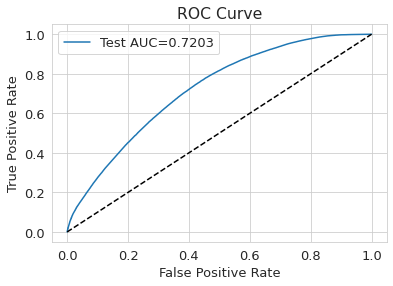

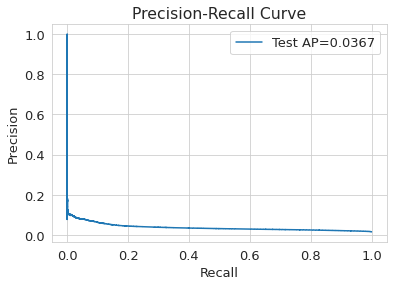

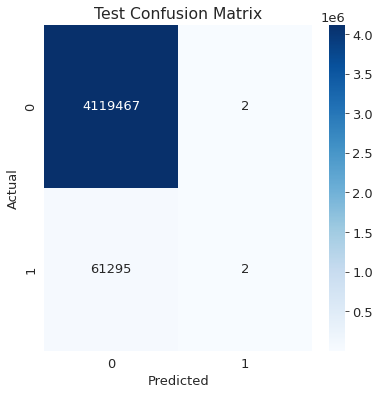

In [141]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, average_precision_score,
    log_loss, roc_curve, precision_recall_curve
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

X_train = pd.read_csv('xgboost_X_train_C.csv')
y_train = pd.read_csv('xgboost_y_train_C.csv', header=None).values.flatten()
X_test = pd.read_csv('xgboost_X_test_C.csv')
y_test = pd.read_csv('xgboost_y_test_C.csv', header=None).values.flatten()

print("\nColumns in X_train:")
print(list(X_train.columns))

print("\nColumns in X_test:")
print(list(X_test.columns))

y_train = y_train[1:].astype(int)
y_test = y_test[1:].astype(int)

categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'min_child_weight': 7,
    'reg_lambda': 1,
    'reg_alpha': 1.1,
    'eta': 0.11,
    'max_depth': 11,
    'colsample_bytree': 0.5,
    'seed': 45
}

early_stopping_rounds = 90
evals = [(dval, 'validation')]
num_boost_round = 300

print("\nTraining XGBoost model with test data as validation set...")
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True,
)

baseline_ctr = y_train.mean()
baseline_loss = -(
    baseline_ctr * np.log(baseline_ctr + 1e-9) +
    (1 - baseline_ctr) * np.log(1 - baseline_ctr + 1e-9)
)

test_preds = model.predict(dval)
test_loss = log_loss(y_test, test_preds)
test_rig = (1 - test_loss / baseline_loss) * 100
test_accuracy = accuracy_score(y_test, test_preds >= 0.5)
test_auc = roc_auc_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds >= 0.5, zero_division=0)
test_recall = recall_score(y_test, test_preds >= 0.5, zero_division=0)
test_f1 = f1_score(y_test, test_preds >= 0.5, zero_division=0)
test_cm = confusion_matrix(y_test, test_preds >= 0.5)
test_ap = average_precision_score(y_test, test_preds)
test_gini = 2 * test_auc - 1
Y_Avg = test_preds.mean()

print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}, RIG: {test_rig:.2f}%, AUC: {test_auc:.4f}, Gini: {test_gini:.4f}")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
print(f"Average Precision (AP): {test_ap:.4f}, Mean Y Predicted: {Y_Avg:.4f}")
print("Confusion Matrix:")
print(test_cm)

fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"Test AUC={test_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

precision_test, recall_test, _ = precision_recall_curve(y_test, test_preds)
plt.figure()
plt.plot(recall_test, precision_test, label=f"Test AP={test_ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

test_data = pd.read_csv("preprocessed_test_data.csv").copy()

if len(test_data) != len(test_preds):
    raise ValueError("Mismatch between test_data and test_preds length.")

test_data['Predicted_Y'] = test_preds
test_data['Actual_Y'] = y_test

print("Test data with predictions saved to 'XGB_test_data_with_predictions.csv'.")

model.save_model("xgb_model_C.bin")
print("XGBoost model saved to 'xgb_model.bin'.")

### Counterfactual Estimation: Contextual Model

Using the trained contextual XGBoost model, we generate counterfactual predictions to evaluate how expected engagement would change under alternative ad assignments. We first compute factual predicted click probabilities for each test impression given the observed ad.

We then construct counterfactual outcomes by systematically replacing the ad identifier (`CURRENT_AD_ID`) with alternative ad IDs while holding all other contextual features fixed. This yields impression-level predicted click probabilities for a fixed set of counterfactual ads.

The resulting dataset contains impression identifiers, factual predictions, observed outcomes, the actual ad shown, and predicted counterfactual outcomes for each alternative ad. This structure supports counterfactual policy evaluation under a purely contextual information regime.


In [142]:
import pandas as pd, numpy as np, xgboost as xgb

print("Loading saved model and test matrices …")
MODEL_PATH = "xgb_model_C.bin"
XTEST_PATH = "xgboost_X_test_C.csv"
YTEST_PATH = "xgboost_y_test_C.csv"
PREPROC_TEST = "preprocessed_test_data.csv"

booster = xgb.Booster()
booster.load_model(MODEL_PATH)

X_test = pd.read_csv(XTEST_PATH)
y_test = pd.read_csv(YTEST_PATH, header=None).values.flatten()[1:].astype(int)

meta_test = pd.read_csv(PREPROC_TEST)
if len(meta_test) != len(X_test):
    raise ValueError("Row mismatch between feature matrix and meta file.")

unique_id_col = "Unique_ID" if "Unique_ID" in meta_test.columns else meta_test.columns[0]
unique_ids = meta_test[unique_id_col].values
actual_ad_col = "CURRENT_AD_ID"
actual_ads = meta_test[actual_ad_col].values

ad_feat_col = "CURRENT_AD_ID"
if ad_feat_col not in X_test.columns:
    raise ValueError(f"Feature column '{ad_feat_col}' not found in X_test!")

dtest = xgb.DMatrix(X_test)
factual_pred = booster.predict(dtest)

NUM_ADS_CF = 10
cf_preds = np.zeros((len(X_test), NUM_ADS_CF))

print("Predicting counter-factuals …")
for ad_id in range(NUM_ADS_CF):
    X_cf = X_test.copy()
    X_cf[ad_feat_col] = ad_id
    d_cf = xgb.DMatrix(X_cf)
    cf_preds[:, ad_id] = booster.predict(d_cf)
    print(f"  finished ad {ad_id}")

out_cols = {
    "Unique_ID": unique_ids,
    "Predicted_Y": factual_pred,
    "Actual_Y": y_test,
    "Actual_Ad_ID": actual_ads
}
for ad_id in range(NUM_ADS_CF):
    out_cols[f"cf_ad_{ad_id}"] = cf_preds[:, ad_id]

out_df = pd.DataFrame(out_cols)
out_df.to_csv("Models/val_counterfactual_predictions_Contextual.csv", index=False)
print("✓ counterfactual_predictions.csv written.")

Loading saved model and test matrices …


/tmp/ipykernel_2926469/3704075040.py:31: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  y_test    = pd.read_csv(YTEST_PATH, header=None).values.flatten()[1:].astype(int)
/tmp/ipykernel_2926469/3704075040.py:33: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_test = pd.read_csv(PREPROC_TEST)            # same order as X_test by construction


Predicting counter-factuals …
  finished ad 0
  finished ad 1
  finished ad 2
  finished ad 3
  finished ad 4
  finished ad 5
  finished ad 6
  finished ad 7
  finished ad 8
  finished ad 9
✓ counterfactual_predictions.csv written.
